In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import jieba
# LingPlus is available from https://github.com/seantyh/LingPlus
from LingPlus import nb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# Content
## [Preprocessing](#preproc)
## [Train-Test Split](#ttsplit)
## [Tuning](#tuning)
## [Evaluation](#eval)

In [3]:
def load_csv(fpath):
    fin = open(fpath, "r", encoding="UTF-8")
    csvreader = csv.reader(fin)
    next(csvreader)
    data = []
    for row in csvreader:
        data.append(row)
    return data

In [4]:
data = []
for fpath in glob.glob("data/proc/*.csv"):    
    data += load_csv(fpath)

In [5]:
nTW = len([x for x in data if x[1] == "TW"])
nCN = len([x for x in data if x[1] == "CN"])
print("TW items: ", nTW)
print("CN items: ", nCN)

TW items:  6572
CN items:  7049


<a id="preproc"></a>
# Preprocess data

In [6]:
jieba.set_dictionary("data/as_jieba.txt")
san_pat = re.compile("[\u3400-\u9fff\uf900-\ufaffa-zA-Z0-9]")
import pdb
def do_tokenize(srt_item):    
    srt_tokens = srt_item
    if not isinstance(srt_item[2], str):        
        return srt_item
    tok_iter = map(lambda x: x.group(), san_pat.finditer(srt_item[2]))
    srt_tokens[2] = "".join(tok_iter)
    return srt_tokens

def do_segment(srt_item):    
    seg_item = srt_item
    seg_item[2] = list(jieba.cut(srt_item[2]))
    return seg_item

srt_data = map(do_tokenize, data)
srt_data = map(do_segment, srt_data)
srt_data = list(srt_data)

Building prefix dict from E:\Dropbox\Dropbox\Kyle\LingNLP\Week5\data\as_jieba.txt ...
Loading model from cache C:\Users\Sean\AppData\Local\Temp\jieba.u819fa9d31ffde37e51acb08492816972.cache
Loading model cost 0.255 seconds.
Prefix dict has been built succesfully.


In [7]:
print(srt_data[0:10])
print(srt_data[1010:1020])
print(srt_data[5010:5020])
print(srt_data[8010:8020])

[['1', 'TW', ['銀行']], ['2', 'TW', ['現在', '播放', '喇叭褲']], ['3', 'TW', ['手', '舉高']], ['4', 'TW', ['趴', '在', '地', '上']], ['5', 'TW', ['給我', '趴', '在', '地', '上', '趴下']], ['6', 'TW', ['趴下', '不準動']], ['7', 'TW', ['快']], ['8', 'TW', ['快點']], ['9', 'TW', ['通通', '不準動']], ['10', 'TW', ['趴下']]]
[['1011', 'TW', ['他', '在', '98', '年', '逮過', '我']], ['1012', 'TW', ['你們', '打炮', '不', '戴套', '是', '你', '傢', '的', '事']], ['1013', 'TW', ['要是', '有', '人', '想', '幹掉', '我', '我會', '抓狂']], ['1014', 'TW', ['抓住', '他']], ['1015', 'TW', ['寶貝', '別', '讓', '他', '跑', '瞭']], ['1016', 'TW', ['快想', '辦法']], ['1017', 'TW', ['媽', '的']], ['1018', 'TW', ['載', '我們', '離開', '快', '閃']], ['1019', 'TW', ['我們', '走', '快點']], ['1020', 'TW', ['龍舌蘭']]]
[['516', 'CN', ['我們', '能', '有', '今天', '這樣', '的', '成績', '最', '主要', '是', '因', '爲']], ['517', 'CN', ['對公', '衆', '而言', '我們', '是', '不', '存在', '的']], ['518', 'CN', ['如果', '這個', '視頻', '暗示', '甚至', '直接', '提到', '了', '我們']], ['519', 'CN', ['爲', '了', '所有', '客戶', '的', '利益', '考慮']], ['520', 'CN', ['我', '就', '不

In [8]:
vec = CountVectorizer(analyzer=lambda x: x, tokenizer=lambda x: x) 
lbin = LabelBinarizer()

tag_vec = np.array([x[1] for x in srt_data])
lbin.fit(tag_vec)
text_mat = vec.fit_transform([x[2] for x in srt_data])
print("Vocabulary generated by CountVectorizer: ", len(vec.vocabulary_))

Vocabulary generated by CountVectorizer:  9313


<a id="ttsplit"></a>
# Train-Test data split

In [9]:
train_x, test_x, train_y, test_y = train_test_split(text_mat, tag_vec, test_size=0.2, random_state=12)
print("Verify numbers of tag classes are comparable: ")
print("train TW: %.2f, CN: %.2f" % ((train_y=="TW").sum() / nTW, (train_y=="CN").sum() / nCN))

Verify numbers of tag classes are comparable: 
train TW: 0.80, CN: 0.80


<a id="tuning"></a>
# K-Fold(Stratified) model tuning

In [10]:
sm_list = [0, 0.1,0.5,1,2,4]
sm_acc = []
for sm_alpha in sm_list:
    print("--- Smooth alpha: %f ---" % sm_alpha)    
    acc = nb.smooth_selection(sm_alpha, train_x, train_y)
    sm_acc.append(acc)


--- Smooth alpha: 0.000000 ---
Accuracy average: 0.5896
--- Smooth alpha: 0.100000 ---
Accuracy average: 0.6255
--- Smooth alpha: 0.500000 ---
Accuracy average: 0.6311
--- Smooth alpha: 1.000000 ---
Accuracy average: 0.6354
--- Smooth alpha: 2.000000 ---
Accuracy average: 0.6373
--- Smooth alpha: 4.000000 ---
Accuracy average: 0.6326


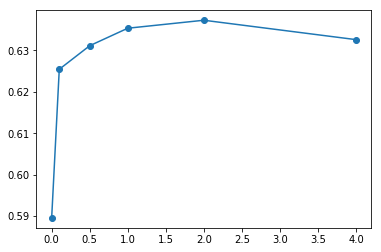

In [11]:
plt.plot(sm_list, sm_acc, '-o')

<a id="eval"></a>
# Model Evaluation with Test Data

In [12]:
# model training
enc_train_y = lbin.transform(train_y)
pY = enc_train_y.sum() / len(enc_train_y)
with tf.Graph().as_default() as g:
    model = nb.train(train_x, enc_train_y,
                    pY_prior=pY, smooth_alpha=2)

# model testing
with tf.Graph().as_default() as g:
    test_pred_vec = nb.predict(model, test_x)
    
test_pred_y = lbin.inverse_transform(np.array(test_pred_vec))
acc = accuracy_score(test_y, test_pred_y)
prec = precision_score(test_y, test_pred_y, pos_label="TW")
recall = recall_score(test_y, test_pred_y, pos_label="TW")
f1 = f1_score(test_y, test_pred_y, pos_label="TW")
    
print(lbin.classes_)
print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f, F1: %.2f" 
      % (acc, prec, recall, f1))


['CN' 'TW']
Accuracy: 0.64, Precision: 0.68, Recall: 0.52, F1: 0.59


In [13]:
confusion_matrix(test_y, test_pred_y)

array([[1046,  335],
       [ 643,  701]], dtype=int64)

# Discussion

* Final model has accuracy of 64%, F1-score is 0.59.
* Performance may be better if using tf-idf when generating word features.
* Segmentation was still an issue, since no special care was taken when segmenting China subtitles.
* Word encoder in preprocessing step used whole data to calculate vocabulary. It should honor the train-test data split next time, where vocabulary is only built from training data.